In [3]:
import pandas as pd
import psycopg2 as pg
import pandas.io.sql as psql

In [5]:
# postgre sql 연결 후 데이터 df 로 불러오기 
with pg.connect(database = 'postgres',
                user = 'postgrres',
                host = 'localhost',
                password = '',
                port = 5432) as conn:

  sql = 'SELECT * FROM seoul'

  df = psql.read_sql(sql, conn)

In [6]:
# df 확인
df.head()

,측정일자,권역명,측정소명,미세먼지,초미세먼지,오존,이산화질소농도,일산화탄소농도,아황산가스농도
0,2022-06-06,도심권,중구,6.0,4.0,0.030,0.008,0.3,0.003
1,2022-06-06,도심권,종로구,8.0,4.0,0.029,0.006,0.3,0.003
2,2022-06-06,도심권,용산구,9.0,5.0,0.035,0.008,0.2,0.003
3,2022-06-06,서북권,은평구,11.0,7.0,0.029,0.005,0.3,0.002
4,2022-06-06,서북권,서대문구,7.0,2.0,0.032,0.004,0.3,0.004


In [7]:
# 필요한 데이터만 추리기
df = df[['측정일자', '초미세먼지', '오존', '이산화질소농도', '일산화탄소농도', '아황산가스농도' ]]

In [8]:
# 컬럼명 조정
df.columns = ['Date', 'PM25', 'O3', 'NO2', 'CO', 'SO2']

In [9]:
# 확인
df.head()

,Date,PM25,O3,NO2,CO,SO2
0,2022-06-06,4.0,0.030,0.008,0.3,0.003
1,2022-06-06,4.0,0.029,0.006,0.3,0.003
2,2022-06-06,5.0,0.035,0.008,0.2,0.003
3,2022-06-06,7.0,0.029,0.005,0.3,0.002
4,2022-06-06,2.0,0.032,0.004,0.3,0.004


In [10]:
# 결측치 확인
df.isnull().sum() 

Date    0
PM25    0
O3      0
NO2     0
CO      0
SO2     0
dtype: int64

In [11]:
# 타겟과 상관관계 확인
df.corr()['PM25']

PM25    1.000000
O3     -0.108913
NO2     0.594016
CO      0.657472
SO2     0.399968
Name: PM25, dtype: float64

In [ ]:
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


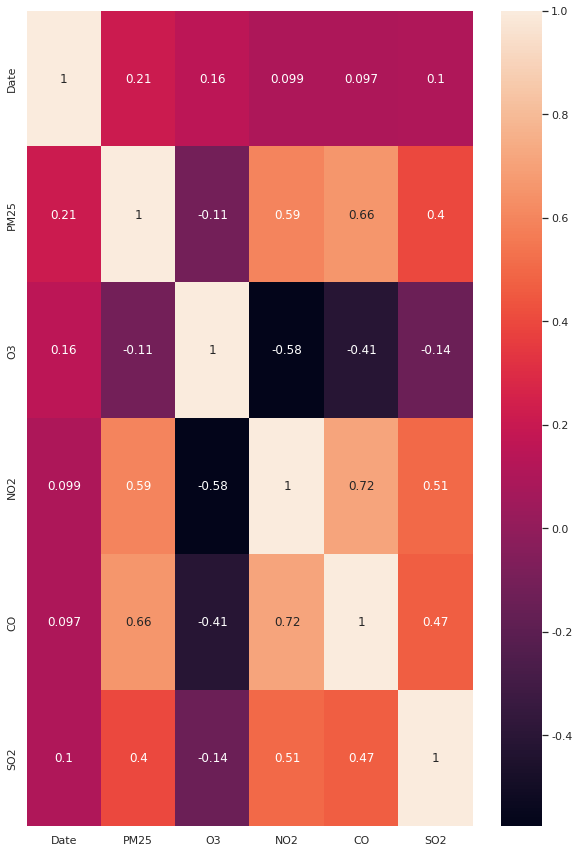

In [ ]:
# 타겟 상관관계 분석 히트맵
sns.set(rc = {'figure.figsize':(10,15)})
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)
sns.heatmap(df.corr(), annot=True)

In [ ]:
# 타겟의 평균(베이스라인)
df['PM25'].mean()

19.11303867403315

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import pickle

In [ ]:
# 학습전 데이터 분리
feature = df[['SO2', 'CO', 'NO2']]
target = df[['PM25']]
X = feature
y = target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=2)
X_train.shape, X_val.shape
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, random_state=2)

In [ ]:
# 학습
model = xgb.XGBRegressor(n_estimators= 2000, max_depth = 16)
model = model.fit(X_train, y_train, early_stopping_rounds=100, verbose=False, eval_set=[(X_val, y_val)])

/root/.local/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


In [ ]:
# 평가지표 확인
y_pred= model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
display(pd.DataFrame([['MSE', mse],['MAE', mae],['RMSE', rmse],['R2', r2]], columns=['Metric', 'Score']))

,Metric,Score
0,MSE,99.622676
1,MAE,6.807752
2,RMSE,9.981116
3,R2,0.443890


In [ ]:
# 저장
filename = 'xgb_model.model'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
# 불러오기
xgb_model = pickle.load(open(filename, 'rb'))

In [ ]:
# 예측값 확인
arr = pd.DataFrame({'SO2': [0.003], 'CO': [0.3], 'NO2' : [0.002]})

In [ ]:
# 예측
xgb_model.predict(arr)[0]

3.2659829